In [1]:
'''
very simple CNN for MNIST 
based on
https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD, Adam
from keras.callbacks import Callback

from keras import backend as K


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np

from keras.callbacks import TensorBoard

Using TensorFlow backend.


ModuleNotFoundError: No module named 'seaborn'

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

# this is fixed, we have 10 digits in our data set
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## X_train is of shape n_samples x 28 x 28
## for a CNN we want to keep the image shape
## need to explicitly tell keras that it is a gray value image
## so each image is 28x28x1 not 28x28x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [31]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
# number of iterations over the complete training data
epochs = 1

for n_conv_layers in [1,2]:
    for n_dense_layers in [1,2]:
        log_dir_string = "cv"
        K.clear_session()
        model = Sequential()
        model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape, use_bias=False))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if n_conv_layers == 1:
            log_dir_string += "_1conv"
        else:
            model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape, use_bias=False))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            log_dir_string += "_2conv"
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        
        if n_dense_layers == 1:
            log_dir_string += "_1fc"
        else:
            model.add(Dense(64, activation='relu'))
            log_dir_string += "_2fc"
            
            
        
        model.add(Dense(num_classes, activation='softmax'))

        adam = Adam(lr=0.001)
        model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

        # we need a callback to save information for tensorboard visualizations
        tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string,
                                                  histogram_freq=1, 
                                                  write_graph=False, 
                                                  write_images=True
                                                 )

        history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard])


        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/1
60000/60000 [==============================] - 32s -

InvalidArgumentError: Tensor must be 4-D with last dim 1, 3, or 4, not [5,5,16,16]
	 [[Node: conv2d_2/kernel_0_1 = ImageSummary[T=DT_FLOAT, bad_color=Tensor<type: uint8 shape: [4] values: 255 0 0...>, max_images=3, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_2/kernel_0_1/tag, Squeeze_1)]]

Caused by op 'conv2d_2/kernel_0_1', defined at:
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-8f9229218fdc>", line 48, in <module>
    callbacks=[tensorboard])
  File "/usr/local/lib/python3.6/site-packages/keras/models.py", line 853, in fit
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1486, in fit
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1102, in _fit_loop
    callbacks.set_model(callback_model)
  File "/usr/local/lib/python3.6/site-packages/keras/callbacks.py", line 51, in set_model
    callback.set_model(model)
  File "<ipython-input-29-bb29db336fbf>", line 64, in set_model
    tf.summary.image(weight.name, w_img)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/summary/summary.py", line 177, in image
    name=scope)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 200, in _image_summary
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Tensor must be 4-D with last dim 1, 3, or 4, not [5,5,16,16]
	 [[Node: conv2d_2/kernel_0_1 = ImageSummary[T=DT_FLOAT, bad_color=Tensor<type: uint8 shape: [4] values: 255 0 0...>, max_images=3, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_2/kernel_0_1/tag, Squeeze_1)]]


In [ ]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")


In [ ]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

In [ ]:
# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

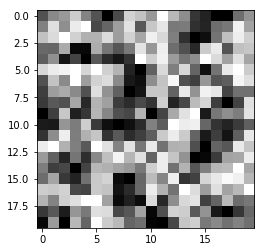

In [11]:
import numpy as np
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

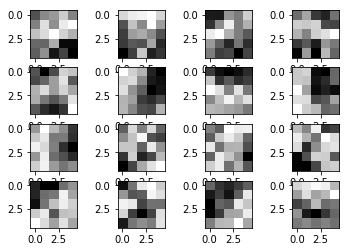

In [12]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()